## PS3: Decision making
### Task 1. Value iteration
First of all, start escaping from maze with value iteration algorithm.


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from typing import Tuple
from utils import plot_joint_enviroment, action_space, transition_function, pursuer_transition
from vi import vi
from tqdm import tqdm
from mcts import mcts

First of all, let`s visualize and observe the environment.

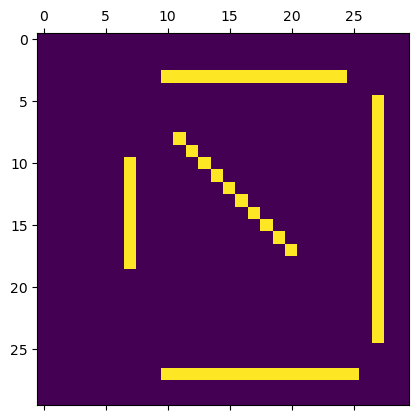

In [68]:
data = np.load('data_ps3.npz')
environment = data['environment']
plt.matshow(environment)

# (row index, colum index). In the image row corresponds to y, and colum to x.
x_e = tuple(data["x_e"])  # (11, 6) you free to use it as np array if you prefer, but utils.py is expecting a tuple
x_p = tuple(data["x_p"])  # (7, 25)
goal = tuple(data["goal"])  # (15, 29)

#### Task 1.1. Action space
Next, let`s go and research and enumerate action space.

In [63]:
for ind, action in enumerate(action_space):
    print(f'{ind} action: ', action)

0 action:  (-1, 0)
1 action:  (0, -1)
2 action:  (1, 0)
3 action:  (0, 1)


#### Task 1.2. Cost-to-go optimality.
Next step, let's describe optimal cost-to-go in recursive form.

$G^{\star}(x) = min_u\left\{l(x, u) + G^{\star}(f(x,u)) \right\}= min_u\left\{1 + G^{\star}(f(x,u))\right\}$ <br>
$G_k^{\star}(x) = min_{u_k}\left\{l(x_k, u_k) + G_{k+1}^{\star}(f(x_k,u_k)) \right\}= min_{u_k}\left\{1 + G_{k+1}^{\star}(f(x_k,u_k))\right\}$ <br>
$u^{\star} = argmin(l(x+u) + G^{\star}(f(x, u)))$

#### Task 1.3. Value iteration algorithm
Now, we are ready to create value iteration algorithm.

In [70]:
def action_loop(env: np.array, state: Tuple) -> np.array:
    new_pos = []
    if env[state] >= 1.0 - 1e-4:
        return np.array([])
    for action in action_space:
        new_state, condition = transition_function(env, state, action)
        if condition:
            new_pos.append(new_state)
    return np.array(new_pos)

def decrypt(step: Tuple) -> int:
    if step == (-1,0):
        return 0
    if step == (0,-1):
        return 1
    if step == (1, 0):
        return 2
    if step == (0, 1):
        return 3    


def vi(env: np.array, goal: Tuple) -> (np.array, np.array):
    """
    env is the grid enviroment
    goal is the goal state
    """
    policy, cost_to_go = np.zeros(env.shape, 'b'), np.ones(env.shape) * 1e2
    cost_to_go[goal[0], goal[1]] = 0
    while True:
        cost_to_go_prev = np.copy(cost_to_go)
        for i in range(env.shape[0]):
            for j in range(env.shape[1]):
                next_states = action_loop(env, (i, j))
                Q = []
                for next_state in next_states:
                    Q.append((next_state, 1 + cost_to_go[next_state[0], next_state[1]]))
                if(len(Q) == 0):
                    continue
                min_value = 100
                min_elem = Q[0][0]
                for k in Q:
                    if k[1] < min_value:
                        min_elem = k[0]
                        min_value = k[1]
                cost_to_go[i,j] = min(min_value, cost_to_go[i,j])
                policy[i][j] = decrypt((min_elem[0] - i, min_elem[1] -j))
        if np.sum(cost_to_go - cost_to_go_prev) == 0:
            break 
    return policy, cost_to_go


Let's visualize cost-to-go matrix.

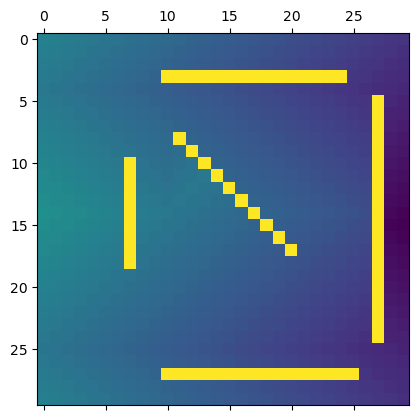

In [65]:
default_policy, Gopt = vi(environment, goal)
plt.matshow(Gopt)

First, run our algorithm without pursuer.

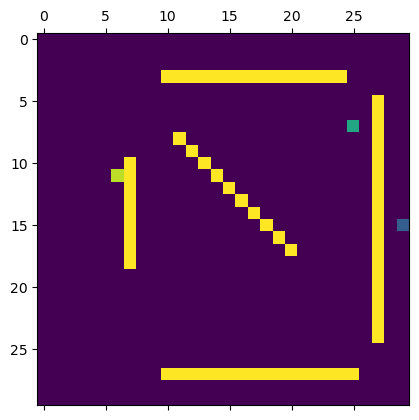

x_e: (15, 28), x_p: (7, 25), distance to goal: 1.00 distance to pursuer: 8.54:  40%|████      | 40/100 [00:00<00:00, 690.98it/s]


WIN!


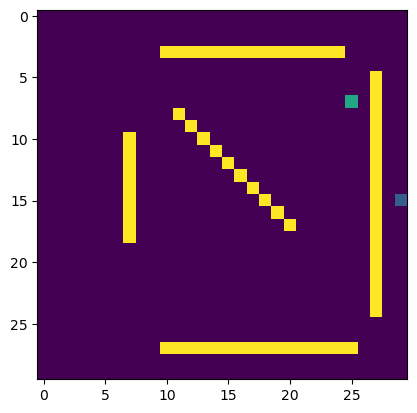

In [66]:
# Visualization
# ======================================
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plt.matshow(im)
plt.show()

# The Game
fig = plt.figure()
imgs = []
pbar = tqdm(range(100))

for s in pbar:
    im = plot_joint_enviroment(environment, x_e, x_p, goal)
    plot = plt.imshow(im)
    imgs.append([plot])

    u_e = action_space[default_policy[x_e]] 
    x_e, _ = transition_function(environment, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break
    if x_p == x_e:
        print('game over((')
        break
    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')

im = plot_joint_enviroment(environment, x_e, x_p, goal)
plot = plt.imshow(im)
imgs.append([plot])
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)

ani.save('scape_solve.mp4')

plt.show()

#### Task 1.4 Escape the maze
Return x_e to start position and uncomment the pursuer movement and check the result.

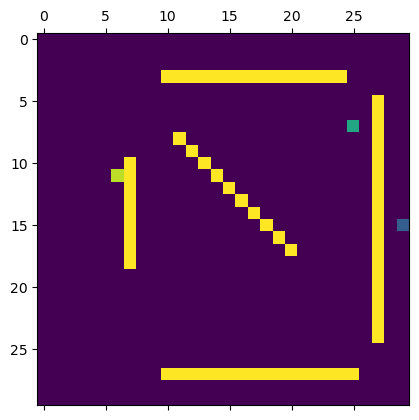

x_e: (4, 12), x_p: (5, 13), distance to goal: 20.25 distance to pursuer: 1.41:  13%|█▎        | 13/100 [00:00<00:00, 620.88it/s]


game over((


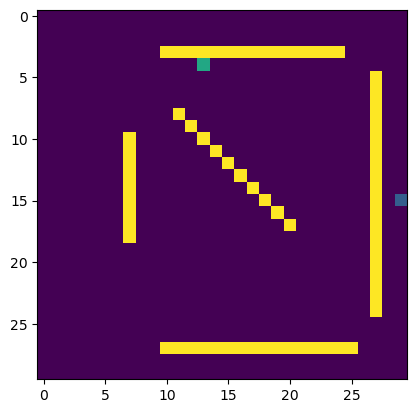

In [69]:
x_e = tuple(data['x_e'])
# Visualization
# ======================================
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plt.matshow(im)
plt.show()

# The Game
fig = plt.figure()
imgs = []
pbar = tqdm(range(100))

for s in pbar:
    im = plot_joint_enviroment(environment, x_e, x_p, goal)
    plot = plt.imshow(im)
    imgs.append([plot])

    u_e = action_space[default_policy[x_e]] 
    x_e, _ = transition_function(environment, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break
    
    x_p = pursuer_transition(environment,x_e, x_p)
    if x_p == x_e:
        print('game over((')
        break
    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')

im = plot_joint_enviroment(environment, x_e, x_p, goal)
plot = plt.imshow(im)
imgs.append([plot])
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)

ani.save('scape_solve_with_pursuer_vi.mp4')

plt.show()

Comment: we lost because pursuer catch evader.

### Task 2. Monte Carlo tree search
#### Task 2.1. Expanding only to non-visited states
The main problem with standart trees is the number of leaves which increase with exponent. So, we should visit only non-visited states in Monte Carlo tree search to reduce number of states and reduce time complexity. In empty space with 4 possible actions, tree with depth 5 will have $2^6-1 = 65$ nodes. And this number will increase. So, we do not visit same states twice, if we add it to the tree, we have already calculate it reward.

#### Task 2.1. Monte Carlo tree search.
Now, let`s implement Monte Carlo tree search with policy, which was described. Let'r run it several times, until we do not win the gamw.

In [57]:
x_e = tuple(data["x_e"])
tree = {}
#tree{ node: {parent: Tuple, reward: int, visits: int, children: List}}

def uct(node: Tuple, C=np.sqrt(0.1)) -> Tuple:
    children = tree[node]['children']
    children_weights = [(tree[child]['reward'] / tree[child]['visits']) + C * np.sqrt(np.log(tree[node]['visits']) / tree[child]['visits']) 
                        for child in children]
    return np.argmax(children_weights)
    


def selection(env: np.array, node_: Tuple, default_policy):
    reward = 0
    node = node_
    while True:
        x_e, _ = transition_function(env, node, action_space[default_policy[node]])
        
        if not x_e in tree:
            tree[node]['children'].append(x_e)
            tree[x_e] = {'parent': node, 'reward': 0, 'visits': 0, 'children': []}
            return x_e
        states = action_loop(env, node)
        for state in states:
            if not tuple(state) in tree:
                tree[node]['children'].append(tuple(state))
                tree[tuple(state)] = {'parent': node, 'reward': 0, 'visits': 0, 'children': []}
                return tuple(state)
        if len(tree[node]['children']) == 0:
            return
        else:
            child_reward = [tree[child]['reward'] for child in tree[node]['children']]
            ind = np.argmax(child_reward)
            node = tree[node]['children'][ind]

def simulate(env: np.array, x_e: Tuple, x_p: Tuple, goal: Tuple, k_budget, default_policy):
    reward = 0
    for i in range(k_budget):
        dist = np.linalg.norm(np.array(x_e) - np.array(goal))

        if x_e == goal:
            reward += 100
            return reward
        if x_e == x_p:
            return 0
        reward += 0.1/dist
        action = action_space[default_policy[x_e]]
        x_e, _ = transition_function(env, x_e, action)
        x_p = pursuer_transition(env, x_e, x_p)
    return reward

def backpropogation(node: Tuple, reward: int):
    while node != None:
        tree[node]['reward'] += reward
        tree[node]['visits'] += 1
        node = tree[node]['parent']

def mcts(env: np.array, x_e: Tuple, x_p: Tuple, goal: Tuple, k_budget, default_policy) -> Tuple:
    """
    Monte-Carlo tree search
    env is the grid enviroment
    x_e evader
    x_p pursuer
    goal is the goal state
    """
    node_ = selection(env, x_e, default_policy)
    if type(node_) == type((1,2)):
        reward = simulate(env, node_, x_p, goal, k_budget, default_policy)
        backpropogation(node_, reward)
    ind = uct(x_e)
    u = (tree[x_e]['children'][ind][0] - x_e[0], tree[x_e]['children'][ind][1] - x_e[1])
    return u


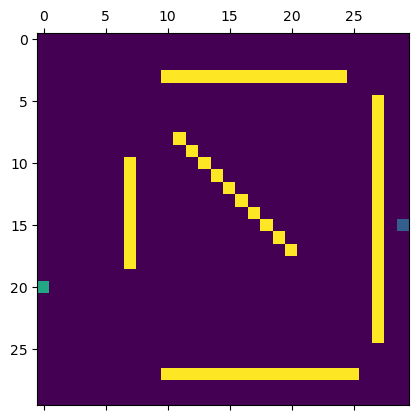

x_e: (15, 28), x_p: (13, 22), distance to goal: 1.00 distance to pursuer: 6.32:  70%|███████   | 70/100 [00:00<00:00, 340.80it/s]  


WIN!


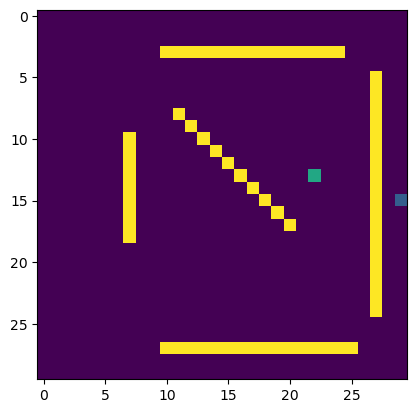

In [60]:
im = plot_joint_enviroment(environment, x_e, x_p, goal)
plt.matshow(im)
plt.show()
x_e = tuple(data["x_e"])
x_p = tuple(data["x_p"]) 

# The Game
fig = plt.figure()
imgs = []
pbar = tqdm(range(100))
tree[x_e] = {'parent': None, 'reward': 0, 'visits': 0, 'children': []}
for s in pbar:
    im = plot_joint_enviroment(environment, x_e, x_p, goal)
    plot = plt.imshow(im)
    imgs.append([plot])


    u_e = mcts(environment, x_e, x_p, goal, 100, default_policy)
    x_e, _ = transition_function(environment, x_e, u_e)
    if x_e == goal:
        print('WIN!')
        break

    x_p = pursuer_transition(environment,x_e, x_p)
    if x_p == x_e:
        print('game over((')
        break
    pbar.set_description(f'x_e: {x_e}, x_p: {x_p},'
                         f' distance to goal: {np.linalg.norm(np.array(x_e) - np.array(goal)):0.2f}'
                         f' distance to pursuer: {np.linalg.norm(np.array(x_e) - np.array(x_p)):0.2f}')

im = plot_joint_enviroment(environment, x_e, x_p, goal)
plot = plt.imshow(im)
imgs.append([plot])
ani = animation.ArtistAnimation(fig, imgs, interval=100, blit=True)

ani.save('scape_solve_with_pursuer.mp4')

plt.show()